In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms

import sys
import numpy as np
import seaborn as sns
sys.path.append('..')
sys.path.append('../stylegan3')

from stylegan_generator import StyleGANGenerator

import matplotlib.pyplot as plt

from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

from pytorch_nn_a import TorchRegressionTraining

In [2]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [19]:
class LatentAutoEncoderA(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.name = 'latent_autoencoder_a'
        self.encoder = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024))
        
        self.decoder = nn.Sequential(
            nn.Linear(1025, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512))            
        
    def forward(self, x, y):
        latent = self.encoder(x)
        x = self.decoder(torch.cat((y.reshape((y.shape[0],-1)), latent),1))
        return x,latent

In [20]:
class LatentAutoEncoderB(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.name = 'latent_autoencoder_b'
        self.encoder = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256))
        
        self.decoder = nn.Sequential(
            nn.Linear(257, 256),
            nn.ReLU(),
            nn.Linear(256, 512)) 
        
    def forward(self, x, y):
        latent = self.encoder(x)
        x = self.decoder(torch.cat((y.reshape((y.shape[0],-1)), latent),1))
        return x,latent

In [3]:
class LatentAutoEncoderC(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.name = 'latent_autoencoder_c'
        self.encoder = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512))
        
        self.feature = nn.Sequential(
            nn.Linear(3,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256,512),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512)) 
        
    def forward(self, x, y):
        latent = self.encoder(x)
        feature = self.feature(y)
        x = self.decoder(torch.cat((feature, latent),1))
        return x,latent

In [4]:
batch_size = 16
num_epochs = 10
learning_rate = 1e-4

data_path = '/home/robert/data/diploma-thesis/datasets/stylegan3/tpsi_1/latents/sample_z.h5'
labels_path = '/home/robert/data/diploma-thesis/predictions/stylegan3/tpsi_07/resnet34_10attr.pkl'

model = LatentAutoEncoderC()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

save_filename = model.name + '_multilabel.pt'

experiment = Experiment(
  api_key = "MqskAFE0NPXT89J9t3bXaz6ac",
  project_name = "pytorch-latent-autoencoder",
  workspace="wicwik"
)

hyper_params = {
'learning_rate': learning_rate,
'batch_size': batch_size,
'loss': 'MSELoss',
'optimizer': "Adam",
'save_filename': save_filename,
'n_parameters': count_parameters(model)
}

experiment.set_name(model.name + '_multilabel')
experiment.log_parameters(hyper_params)

log_model(experiment, model, model_name=model.name)
experiment.set_model_graph(model, overwrite=False)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/wicwik/pytorch-latent-autoencoder/298244fc20594931a22a2a8126b95728



In [5]:
trainer = TorchRegressionTraining(model=model, latents_path=data_path, labels_path=labels_path, loss_fn=criterion, optimizer=optimizer, batch_size=batch_size, save_filename=save_filename, experiment=experiment, multilabel=True)
trainer.run_training(epochs=num_epochs)

cuda
Epoch 1
-------------------------------
loss: 1.031192  [    0/204800] time: 0.8915934562683105 mae: 0.8106204271316528 r2: -0.07920171320438385
loss: 0.869765  [ 8000/204800] time: 2.6044464111328125 mae: 0.7429805397987366 r2: 0.08498848974704742
loss: 0.674580  [16000/204800] time: 2.8390092849731445 mae: 0.6537171602249146 r2: 0.2400939166545868
loss: 0.558880  [24000/204800] time: 2.8828608989715576 mae: 0.5965666174888611 r2: 0.3587484657764435
loss: 0.504420  [32000/204800] time: 2.7548975944519043 mae: 0.5661927461624146 r2: 0.4364665448665619
loss: 0.450471  [40000/204800] time: 2.7017617225646973 mae: 0.5364696979522705 r2: 0.49618589878082275
loss: 0.384162  [48000/204800] time: 3.114199161529541 mae: 0.49371176958084106 r2: 0.5490435361862183
loss: 0.358878  [56000/204800] time: 2.4631590843200684 mae: 0.47815266251564026 r2: 0.5725810527801514
loss: 0.326530  [64000/204800] time: 2.6608636379241943 mae: 0.45674100518226624 r2: 0.616352915763855
loss: 0.301613  [72000/

In [ ]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/wicwik/pytorch-latent-autoencoder/ef596f0b142f4c64aa30509fad63ee32
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     avg_test_loss_per_epoch       : 0.007475564911869083
COMET INFO:     avg_test_mae_per_epoch        : 0.06670431771599655
COMET INFO:     avg_test_r2_per_epoch         : 0.9908716568710111
COMET INFO:     avg_train_loss_per_epoch [10] : (0.006444127568582738, 0.6764371863622094)
COMET INFO:     avg_train_mae_per_epoch [10]  : (0.061762853753143825, 0.6508873927619664)
COMET INFO:     avg_train_r2_per_epoch [10]   : (0.25055506866210514, 0.9920887294471131)
COMET INFO:     avg_valid_loss_per_epoch [10] : (0.

In [7]:
network_pkl = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-1024x1024.pkl'
generator = StyleGANGenerator(network_pkl)

In [35]:
model = LatentAutoEncoderA().cuda()
save_filename = model.name + '.pt'
model.load_state_dict(torch.load(save_filename))

<All keys matched successfully>

In [36]:
rnd = np.random.RandomState(123)
latents = rnd.randn(9, 512)

In [37]:
model.eval()
with torch.no_grad():
    x = torch.Tensor(latents).cuda()
    labels = torch.ones(len(x)).cuda()
    print(labels)
    shifted, _ = model(x, labels)

shifted = shifted.cpu().numpy()

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')


In [38]:
imgs1 = generator.generate_from(latents, truncation_psi=0.7)
imgs2 = generator.generate_from(shifted, truncation_psi=0.7)

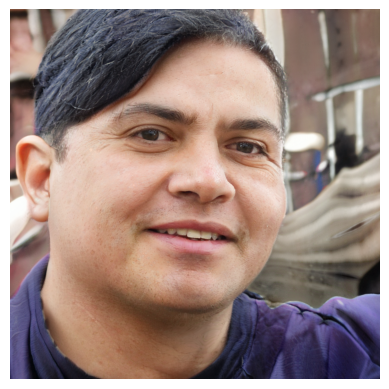

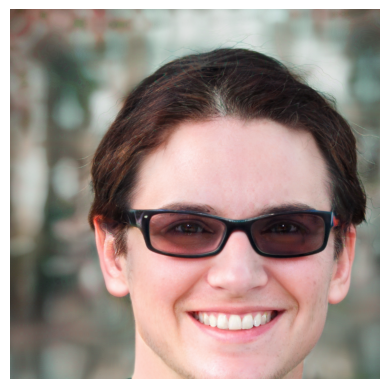

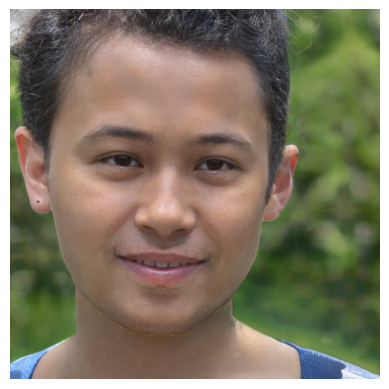

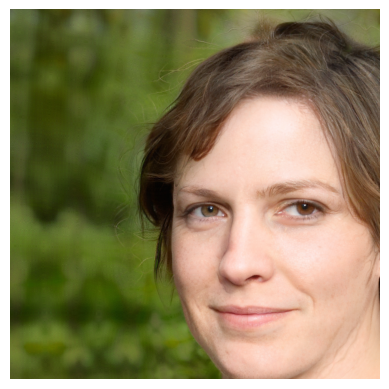

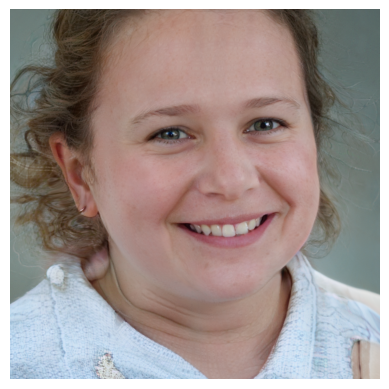

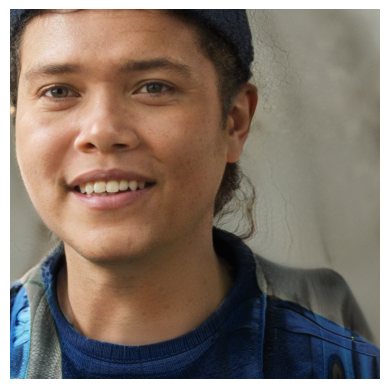

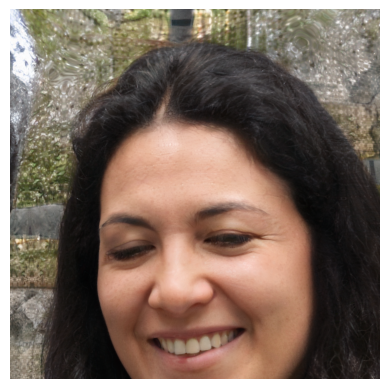

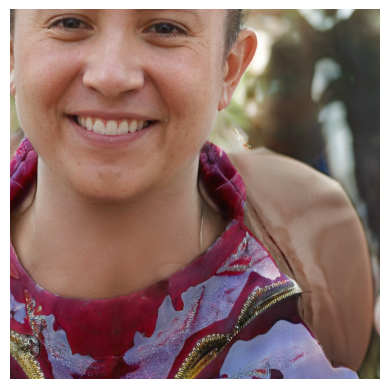

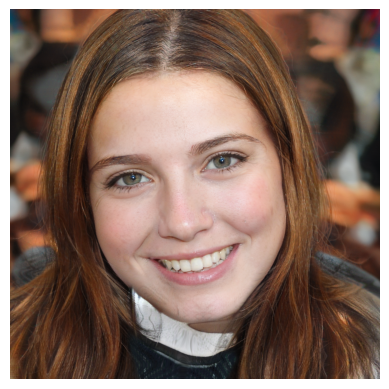

In [39]:
for img in imgs1:
    plt.axis("off")
    plt.imshow(img/255)
    plt.show()

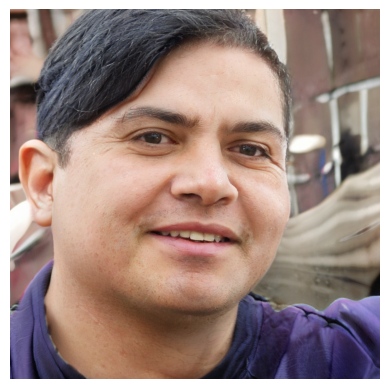

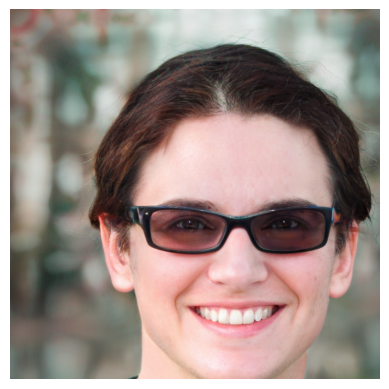

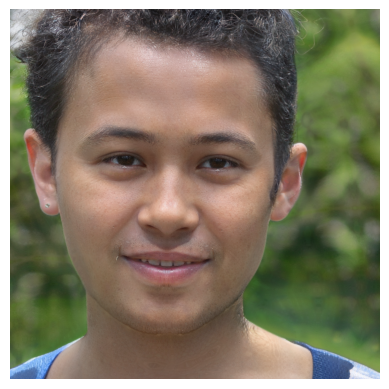

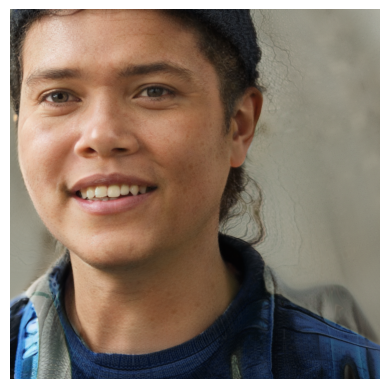

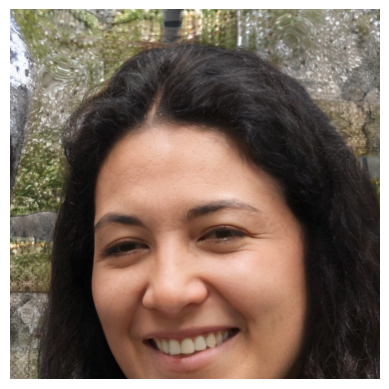

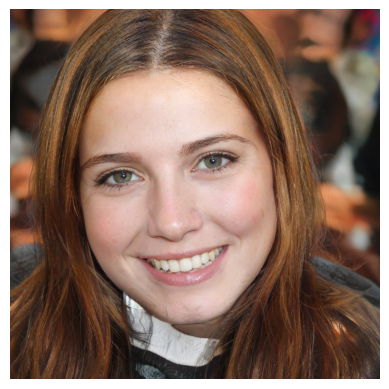

In [40]:
for img in imgs2:
    plt.axis("off")
    plt.imshow(img/255)
    plt.show()

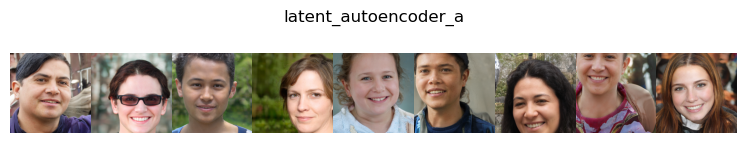

In [41]:
columns = 9 # images
rows = 1
fig = plt.figure(figsize=(columns-1, rows+1))
plt.title(model.name)
fig.tight_layout()
# for each image feature
for i in range(rows):
    # for each image in current feature
    
    for j in range(columns):
        plt.axis('off')
   
        ax = fig.add_subplot(rows, columns, i*columns+j+1)
        
        # right next to each other
 
        plt.imshow(imgs2[j]/255) # show image

        plt.subplots_adjust(wspace=0.0, hspace=0.0) 


plt.axis('off')
plt.show()

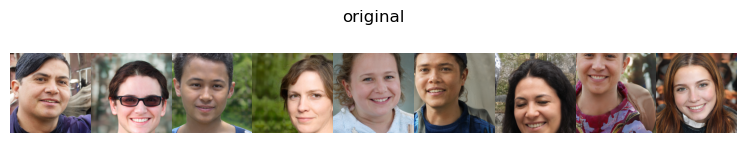

In [42]:
columns = 9 # images
rows = 1
fig = plt.figure(figsize=(columns-1, rows+1))
plt.title('original')
fig.tight_layout()
# for each image feature
for i in range(rows):
    # for each image in current feature
    
    for j in range(columns):
        plt.axis('off')
   
        ax = fig.add_subplot(rows, columns, i*columns+j+1)
        
        # right next to each other
 
        plt.imshow(imgs1[j]/255) # show image

        plt.subplots_adjust(wspace=0.0, hspace=0.0) 


plt.axis('off')
plt.show()